In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from benchmarking import *
% matplotlib inline

from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
#from ZIFA import ZIFA
#from ZINB import ZINB
#from SIMLR import SIMLR

from benchmarking import *

/home/ubuntu/dca/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/dca/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/dca/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/dca/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/dca/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/dca/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning:

In [2]:
data_path = "../single-cell-scVI/data/CBMC/"

# preprocessing

In [39]:
expression = pd.read_csv(data_path + "GSE100866_CBMC_8K_13AB_10X-RNA_umi.csv", index_col=0).T
protein = pd.read_csv(data_path + "GSE100866_CBMC_8K_13AB_10X-ADT_umi.csv", index_col=0).T
norm_protein = pd.read_csv(data_path + "GSE100866_CBMC_8K_13AB_10X-ADT_clr-transformed.csv", index_col=0).T

In [40]:
gene_names = expression.columns
barcodes = expression.index
protein_names = protein.columns

In [41]:
print expression.shape[0], " cells with ", expression.shape[1], " genes and ", norm_protein.shape[1], "proteins"

8617  cells with  36280  genes and  13 proteins


In [42]:
selected = np.std(expression.as_matrix(), axis=0).argsort()[-600:][::-1]
expression = expression.as_matrix()[:, selected]

In [43]:
expression_train, expression_test, c_train, c_test, n_train, n_test = train_test_split(expression, \
                                                                     protein.as_matrix(),\
                                                                     norm_protein.as_matrix(), random_state=0)

In [9]:
np.savetxt(data_path + "expression_train", expression_train)
np.savetxt(data_path + "expression_test", expression_test)
np.savetxt(data_path + "n_train", n_train)
np.savetxt(data_path + "n_test", n_test)
np.savetxt(data_path + "c_train", c_train)
np.savetxt(data_path + "c_test", c_test)

# Benchmarking

In [3]:
expression_train = np.loadtxt(data_path + "expression_train")
expression_test = np.loadtxt(data_path + "expression_test")
n_train = np.loadtxt(data_path + "n_train")
n_test = np.loadtxt(data_path + "n_test")

In [4]:
n_latent = 10

In [5]:
nne = NearestNeighbors(n_neighbors=101, n_jobs=8)
%time nne.fit(n_train)
%time kmatrix_prot = nne.kneighbors_graph(n_train) - scipy.sparse.identity(n_train.shape[0])

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 4.26 ms
CPU times: user 1.85 s, sys: 8 ms, total: 1.86 s
Wall time: 517 ms


In [6]:
def score_latent(latent, protein_data, k=100):
    # get a clustering
    #labels = KMeans(10, n_jobs=8, n_init=200).fit_predict(latent)
    
    # get a distance matrix
    #l_dist = scipy.spatial.distance_matrix(latent, latent)
    #p_dist = scipy.spatial.distance_matrix(protein_data, protein_data)
    
    # get the knn graphs
    nne = NearestNeighbors(n_neighbors=k+1, n_jobs=8)
    nne.fit(latent)
    kmatrix_latent = nne.kneighbors_graph(latent) - scipy.sparse.identity(latent.shape[0])

    # work with the sets now 
    set_A = set(np.where(kmatrix_prot.A.flatten() == 1)[0])
    set_B = set(np.where(kmatrix_latent.A.flatten() == 1)[0])
    fold_enrichment = len(set_A.intersection(set_B)) * kmatrix_prot.shape[0] **2  / (float(len(set_A)) * len(set_B))
    
    return scipy.stats.spearmanr(kmatrix_latent.A.flatten(), kmatrix_prot.A.flatten())[0], fold_enrichment
     #silhouette_score(protein_data, labels), \
        #scipy.stats.spearmanr(l_dist.flatten(), p_dist.flatten())[0], \
        #scipy.stats.kendalltau(l_dist.flatten(), p_dist.flatten())[0] \

In [7]:
score_latent(expression_train, n_train)

(0.09741433511485353, 7.1975)

In [9]:
from dca.api import dca
import anndata
train = anndata.AnnData(expression_train)
res = dca(train, verbose=True, mode="latent", hidden_size=(64, 10, 64))
latent = train.obsm['X_dca']
score_latent(latent, n_train)

DCA: Successfully preprocessed 600 genes and 6462 cells.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
count (InputLayer)              (None, 600)          0                                            
__________________________________________________________________________________________________
enc0 (Dense)                    (None, 64)           38464       count[0][0]                      
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 64)           192         enc0[0][0]                       
__________________________________________________________________________________________________
enc0_act (Activation)           (None, 64)           0           batch_normalization_4[0][0]      
____________________________________________________

5815/5815 [==============================] - 1s 245us/step - loss: 0.7646 - val_loss: 0.7853
Epoch 41/300
5815/5815 [==============================] - 1s 246us/step - loss: 0.7639 - val_loss: 0.7844
Epoch 42/300
5815/5815 [==============================] - 1s 248us/step - loss: 0.7644 - val_loss: 0.7863
Epoch 43/300
5815/5815 [==============================] - 1s 246us/step - loss: 0.7636 - val_loss: 0.7871
Epoch 44/300
5815/5815 [==============================] - 1s 246us/step - loss: 0.7646 - val_loss: 0.7844
Epoch 45/300
5815/5815 [==============================] - 1s 247us/step - loss: 0.7623 - val_loss: 0.7888
Epoch 46/300
5815/5815 [==============================] - 1s 247us/step - loss: 0.7632 - val_loss: 0.7854
Epoch 47/300
5815/5815 [==============================] - 1s 248us/step - loss: 0.7626 - val_loss: 0.7872
Epoch 48/300
5815/5815 [==============================] - 1s 248us/step - loss: 0.7622 - val_loss: 0.7794
Epoch 49/300
5815/5815 [==============================] - 1

(0.11369852247733035, 8.2335)

In [93]:
algorithms = [FactorAnalysis(n_components=n_latent)]#, ZIFA(n_components=n_latent)]
alg_names = ["PPCA", "ZIFA"]
alg_logs = [True, True]

In [94]:
for i, alg in enumerate(algorithms):
    if i > 0:
        break
    print i, alg_names[i]
    
    data_train = expression_train
    data_test = expression_test
    
    if alg_logs:
        data_train = np.log(1 + expression_train)
        data_test = np.log(1 + expression_test)
        
    %time alg.fit(data_train)
    latent = alg.transform(data_train)
    
    print score_latent(latent, n_train)
    
    score = alg.score(data_test)
    if alg_logs:
        score -= np.mean(np.sum(data_test, axis=-1))
        
    print score

0 PPCA
CPU times: user 2.15 s, sys: 504 ms, total: 2.66 s
Wall time: 699 ms
(0.099746934926233391, 7.3459)
-263.340960058


In [68]:
zinb = ZINB(n_components=n_latent, learn_V=True)
% time zinb.fit(expression_train)
% time latent = zinb.transform(expression_train)
print zinb.score(expression_test)
print score_latent(latent, n_train)

CPU times: user 7min 43s, sys: 35.4 s, total: 8min 19s
Wall time: 34min 20s
CPU times: user 16.5 s, sys: 7.99 s, total: 24.5 s
Wall time: 1min 47s
-475.228218519
(0.10141150581589038, 7.4518)


In [11]:
simlr = SIMLR(n_clusters=10)
%time simlr.fit_transform(expression_train)
clear_output()

In [69]:
score_latent(simlr.F, n_train)

(0.099619616472917824, 7.3378)

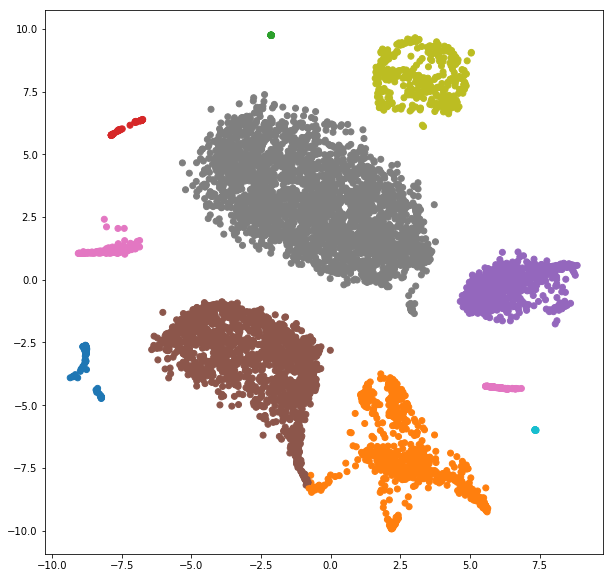

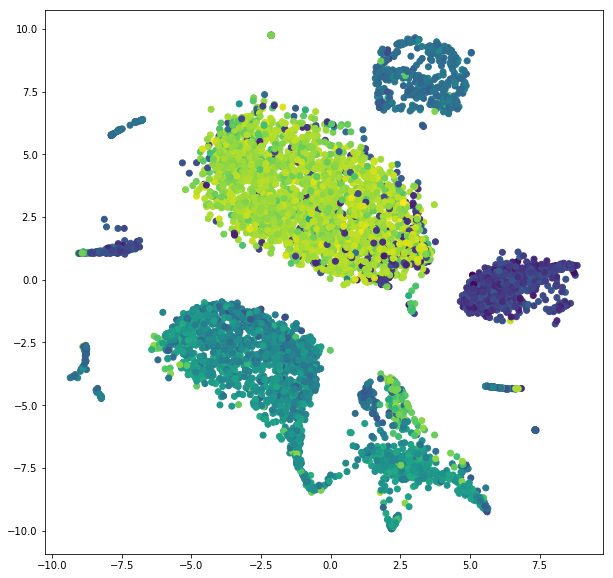

In [13]:
plt.figure(figsize=(10, 10))
plt.scatter(simlr.ydata[:, 0], simlr.ydata[:, 1], c=simlr.clusters, cmap=plt.get_cmap("tab10"))
plt.show()
plt.figure(figsize=(10, 10))
plt.scatter(simlr.ydata[:, 0], simlr.ydata[:, 1], c=n_train[:, 1])

# scVI

In [47]:
%load_ext autoreload
%autoreload 2
from model import scVI_final as scVI
import tensorflow as tf
from benchmarking import *
from helper import *
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
learning_rate = 0.001
epsilon = 0.01
log_library_size = np.log(np.sum(expression_train, axis=1))
mean, var = np.mean(log_library_size), np.var(log_library_size)

In [83]:
tf.reset_default_graph()
expression = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')
kl_scalar = tf.placeholder(tf.float32, (), name='kl_scalar')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
training_phase = tf.placeholder(tf.bool, (), name='training_phase')

model = scVI.scVIModel(expression=expression, kl_scale=kl_scalar, \
                         optimize_algo=optimizer, phase=training_phase, \
                          library_size_mean=mean, library_size_var=var)

# Session creation
sess = tf.Session()

Running scVI on 600 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
1 hidden layers at 128 each for a final 10 latent space


In [84]:
# start a new graph and fit the training set
sess.run(tf.global_variables_initializer())
result = train_model(model, (expression_train, expression_test), sess, 150)
latent = eval_latent(model, expression_train, sess)
score_latent(latent, n_train)

(0.10619144922991411, 7.7559)

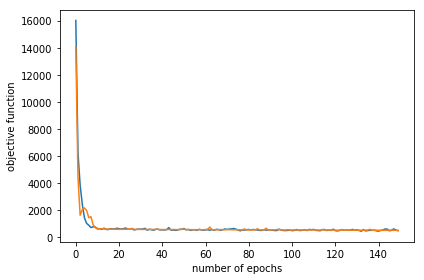

In [27]:
plot_training_info(result)